In [ ]:
# Installing dependencies
!pip install osmnx
!python -m pip uninstall matplotlib -y
!pip install matplotlib==3.1.3

!pip install pywebio
!pip install flask_ngrok

     |████████████████████████████████| 95 kB 2.5 MB/s 
     |████████████████████████████████| 1.0 MB 35.3 MB/s 
     |████████████████████████████████| 11.3 MB 35.2 MB/s 
     |████████████████████████████████| 6.3 MB 44.0 MB/s 
     |████████████████████████████████| 62 kB 517 kB/s 
     |████████████████████████████████| 15.7 MB 60 kB/s 
     |████████████████████████████████| 11.2 MB 37.0 MB/s 
     |████████████████████████████████| 994 kB 43.5 MB/s 
     |████████████████████████████████| 15.4 MB 40 kB/s 
     |████████████████████████████████| 873 kB 47.8 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
     

Found existing installation: matplotlib 3.5.0
Uninstalling matplotlib-3.5.0:
  Successfully uninstalled matplotlib-3.5.0
     |████████████████████████████████| 13.1 MB 91 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.4 which is incompatible.
osmnx 1.1.2 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 339 kB 5.4 MB/s 
  Created wheel for pywebio: filename=pywebio-1.4.0-py3-none-any.whl size=348394 sha256=91cce82798e6c9763ea57a98583c599debf68063c888dc148c48025f180f25c0
  Stored in directory: /root/.cache/pip/wheels/db/7c/3b/853abdef49e39ea18d115f0262ee9e4c0a344bf1ba5439390e
Successfully built pywebio


In [ ]:
# Importing Dependecies
import osmnx as ox
import networkx as nx
import plotly.graph_objects as go
import numpy as np

%matplotlib inline

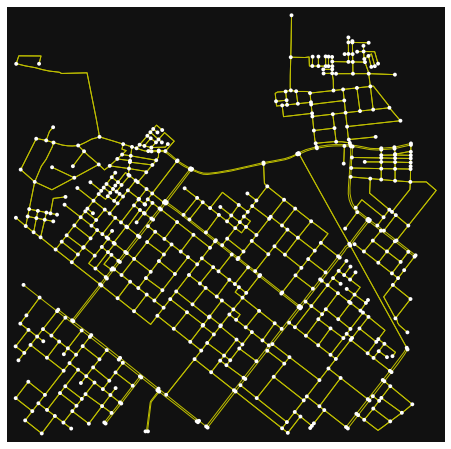

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc3c2806990>)

In [ ]:
north,east,south,west=28.7532,77.1361,28.7288,77.1104    # input the graph detail 

# Downloading the map as a graph object
G = ox.graph_from_bbox(north, south, east, west, network_type = 'drive')
# Plotting the map graph
ox.plot_graph(G, edge_color="y",save=True, filepath="\Map_test.png")

In [ ]:
# Print total nodes and edges in the graph
v=len(G.nodes)
print("Nodes-",v)

e=len(G.edges)
print("Edges-",e)

Nodes- 622
Edges- 1633


In [ ]:
# Creating a dictionary to 0-index the nodes
di={}
index=0
for node in G.nodes(data=True):
  di[node[0]]=[index]     # each value of dictionary correspond to the index
  di[index]=[node[0]]
  index+=1

# Creating list of edges corresponding to 0-indexed nodes
li=[]

for edge in G.edges(data=True):
    src_id=edge[0]
    dst_id=edge[1]
    new_src=di[src_id][0]
    new_dst=di[dst_id][0]
    weight=edge[2]['length']
    li.append([new_src,new_dst,weight])


In [ ]:
# Defining adjacency list function and Dijkstra's Algorithm

from collections import defaultdict
import sys

class Node_Distance :

    def __init__(self, name, dist) :
        self.name = name
        self.dist = dist
parent=[]
parent.clear()
for i in range(v):
    parent.append(i)    
class Graph :

    def __init__(self, node_count) :
        self.adjlist = defaultdict(list)
        self.node_count = node_count

    def Add_Into_Adjlist(self, src, node_dist) :
        self.adjlist[src].append(node_dist)

    def Dijkstras_Shortest_Path(self, source,dst) :

        # Initialize the distance of all the nodes from the source node to infinity
        distance = [999999999999] * self.node_count
        # Distance of source node to itself is 0
        distance[source] = 0

        # Create a dictionary of { node, distance_from_source }
        dict_node_length = {source: 0}

        while dict_node_length :

            # Get the key for the smallest value in the dictionary
            # i.e Get the node with the shortest distance from the source
            current_source_node = min(dict_node_length, key = lambda k: dict_node_length[k])
            del dict_node_length[current_source_node]
            if(current_source_node==dst):
                break

            for node_dist in self.adjlist[current_source_node] :
                adjnode = node_dist.name
                length_to_adjnode = node_dist.dist

                # Edge relaxation
                if distance[adjnode] > distance[current_source_node] + length_to_adjnode :
                    parent[adjnode]=current_source_node
                    distance[adjnode] = distance[current_source_node] + length_to_adjnode
                    dict_node_length[adjnode] = distance[adjnode]
        return distance[dst]

In [ ]:
# Creating the Adjacency list for or graph

g = Graph(v)   # graph with v number of vertex
for i in range(e):    #graph with e number of edges
   g.Add_Into_Adjlist(li[i][0], Node_Distance(li[i][1],li[i][2]))

In [ ]:
from pywebio.platform.flask import webio_view
from flask_ngrok import run_with_ngrok
from pywebio import STATIC_PATH
from flask import Flask, send_from_directory
from pywebio.input import *
from pywebio.output import *
import argparse
from pywebio import start_server
import plotly.graph_objects as go

app = Flask(__name__)
run_with_ngrok(app)   

def node_list_to_path(G, node_list):
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    for u, v in edge_nodes:
        data = min(G.get_edge_data(u, v).values(), key=lambda x: x['length'])

        if 'geometry' in data:
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
    return lines

def plot_path(lat, long, origin_point, destination_point, interPoints):

    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'blue')))
    
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))

    for i in range(len(interPoints)):
      fig.add_trace(go.Scattermapbox(
          name = "Rider Pickup "+str(i+1),
          mode = "markers",
          lon = [interPoints[i][1]],
          lat = [interPoints[i][0]],
          marker = {'size': 12, 'color':'blue'}))

    lat_center = np.mean(lat)
    long_center = np.mean(long)

    fig.update_layout(mapbox_style="open-street-map", mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                     mapbox = {
                         'center': {'lat': lat_center, 'lon': long_center},
                         'zoom': 14})

    return fig

def getRoute(srcPoint, interRider):
  origin_point = eval(srcPoint) #source
  destination_point = (28.7457, 77.1172)   #destination

  # get the nearest nodes to the locations
  origin_node = ox.get_nearest_node(G, origin_point)
  destination_node = ox.get_nearest_node(G, destination_point)


  input_node_id_zero_index=di[origin_node][0]
  output_node_id_zero_indexed=di[destination_node][0]

  # getting all the requested pooled locations
  interPoints = []
  interTemp = list(interRider.split(';'))
  for i in interTemp:
    interPoints.append(eval(i))

  interNodes_non=[]
  interNodes=[]

  for i in interPoints:
    inter_node = ox.get_nearest_node(G, i)
    inter_node_id_zero_index=di[inter_node][0]
    interNodes_non.append(inter_node)
    interNodes.append(inter_node_id_zero_index)

  # Getting all possible combinations of intermediate stops to be made by the user
  nodes=interNodes
  source=input_node_id_zero_index
  destination=output_node_id_zero_indexed
  dS=g.Dijkstras_Shortest_Path(source,destination)

  from itertools import combinations, permutations

  comb=[] 
  for i in range(0,len(nodes)+1):
    for j in (combinations(nodes,i)):
      comb.append(list(j))

  per=[]
  for i in comb:
    for j in permutations(i):
      per.append(list(j))

  newInter=[]

  for i in per:
    temp=[]
    temp=[source]+i+[destination]
    newInter.append(temp)

  Interdist=[]

  for i in newInter:
    dist=0
    temp=[]
    temp.append(i[0])
    for j in range(len(i)-1):
      dist+=g.Dijkstras_Shortest_Path(i[j],i[j+1])
      temp.append(i[j+1])
    l=[]
    l.append(round(dist,2))
    l.append(temp)
    Interdist.append(l)

  optimalRoute=[]
  maxdist=Interdist[0][0]*1.5
  intercount=0
  curdist=0
  print("Max feasible dist-",(maxdist))

  for i in Interdist[:]:
    if(i[0]<=float(maxdist) and intercount<=len(i[1])):
      intercount=len(i[1])
      optimalRoute=i[1]
      curdist=i[0]

  print(optimalRoute, curdist)

  route=[]
  route.clear()

  curoute=[]
  for i in reversed(range(1,len(optimalRoute))):
    cursource=optimalRoute[i-1]
    curdestination=optimalRoute[i]
    g.Dijkstras_Shortest_Path(cursource,curdestination)
    print(curdestination)
    curr=curdestination
    while(curr!=cursource):
      curoute.append(curr)
      curr=parent[curr]
  curoute.append(optimalRoute[0])
  curoute.reverse()

  path=[]
  path.clear()
  for pa in curoute:
      path.append(di[pa][0])

  lines = node_list_to_path(G, path)
  long2 = []
  lat2 = []
  long2.clear()
  lat2.clear()
  for each_line_detail in lines:
      for coordinate in each_line_detail:
          long2.append(coordinate[0])
          lat2.append(coordinate[1])

  return plot_path(lat2, long2, origin_point, destination_point, interPoints)

def campusPool():

  data = input_group("Basic info",[
  input('Enter the driver location', name='driver'),
  input('Enter all riders locations sepearated by semi-colon', name='rider')
  ])

  img = getRoute(data['driver'], data['rider'])
  fig = go.Figure(img)
  fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
  html = fig.to_html(include_plotlyjs="require", full_html=False)
  put_html(html)

  put_column([
    put_text(data['driver'], data['rider']), None
    # , put_text(getRoute(data['driver']))
    ,put_html(html)
  ], size='auto')
    

app.add_url_rule('/', 'webio_view', webio_view(campusPool),
            methods=['GET', 'POST', 'OPTIONS'])

app.run()

#visit http://localhost/tool to open the PyWebIO application.

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://fd95-34-71-222-225.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [19/Nov/2021 13:28:08] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:28:09] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:28:11] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:28:12] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:28:13] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:28:14] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:28:15] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:28:16] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:28:17] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:28:18] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:28:19] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:28:20] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:28:21] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:28:22] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:

Max feasible dist- 1716.0
[143, 434, 595, 462, 458] 1668.94
458
462
595
434


127.0.0.1 - - [19/Nov/2021 13:28:43] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:28:44] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:29:32] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:29:32] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:29:33] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:29:34] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:29:35] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:29:36] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:29:38] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:29:39] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:29:40] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:29:40] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:29:41] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:29:42] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:

Max feasible dist- 1716.0
[143, 434, 595, 462, 458] 1668.94
458
462
595
434


127.0.0.1 - - [19/Nov/2021 13:29:49] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:29:51] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:29:52] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:29:53] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:29:54] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:29:55] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:29:56] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:29:57] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:29:58] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:29:59] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:30:00] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:30:01] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:30:02] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13:30:03] "GET /?app=index HTTP/1.1" 200 -
127.0.0.1 - - [19/Nov/2021 13: